<a href="https://colab.research.google.com/github/mtavakoliangit/uofc_mythesis/blob/main/Mohsen_LessNN_Langmuir_allC1_Functionalkeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
from keras.callbacks import History
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf

In [ ]:
import pickle
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd 
data_df=pd.read_csv('gdrive/My Drive/CO2_Database/groupedC1_minusConstP.csv')

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gas                          1660 non-null   object 
 1   Rock                         1660 non-null   object 
 2   TOC (%)                      1660 non-null   float64
 3   Moisture (%)                 1660 non-null   float64
 4   Temp (C)                     1660 non-null   float64
 5   Pres. (MPa)                  1660 non-null   float64
 6   C1 Excess Sorption (cm3/gr)  1660 non-null   float64
dtypes: float64(5), object(2)
memory usage: 90.9+ KB


In [ ]:
data_df.describe()

,TOC (%),Moisture (%),Temp (C),Pres. (MPa),C1 Excess Sorption (cm3/gr)
count,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000
mean,15.614216,1.095048,56.227952,9.666066,1.494573
std,25.891040,1.894672,16.061273,7.082669,1.379073
min,0.090000,0.000000,30.000000,0.164000,0.001600
25%,2.364292,0.000000,38.000000,3.387500,0.502225
50%,5.150000,0.000000,61.000000,8.434250,1.148400
75%,7.700000,1.720000,65.000000,15.124625,2.052875
max,88.500000,7.340000,150.000000,27.861700,7.036200


In [ ]:
# Function to insert row in the dataframe
def Insert_row(row_number, df, row_value):
	# Starting value of upper half
	start_upper = 0

	# End value of upper half
	end_upper = row_number

	# Start value of lower half
	start_lower = row_number

	# End value of lower half
	end_lower = df.shape[0]

	# Create a list of upper_half index
	upper_half = [*range(start_upper, end_upper, 1)]

	# Create a list of lower_half index
	lower_half = [*range(start_lower, end_lower, 1)]

	# Increment the value of lower half by 1
	lower_half = [x.__add__(1) for x in lower_half]

	# Combine the two lists
	index_ = upper_half + lower_half

	# Update the index of the dataframe
	df.index = index_

	# Insert a row at the end
	df.loc[row_number] = row_value

	# Sort the index labels
	df = df.sort_index()

	# return the dataframe
	return df

In [ ]:
# Define the Langmuir equation
def Langmuir(P, VL, pL):
    V_ads = VL * P / (P + pL)
    return V_ads

#### Adding P=0, sorption=0 to the datasets, counting the number of datasets (experiments):

In [ ]:
i = 0
row_value = [data_df['Gas'][i], data_df['Rock'][i], data_df['TOC (%)'][i], data_df['Moisture (%)'][i], data_df['Temp (C)'][i], 0, 0]
data_df = Insert_row(i, data_df, row_value)

In [ ]:
P = []
sorp = []
polyfit_df = pd.DataFrame(columns=['Gas', 'Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)', 'VL', 'pL'])

In [ ]:
while i < data_df.shape[0] - 1:
    i += 1
    if data_df['Pres. (MPa)'][i] > data_df['Pres. (MPa)'][i-1]:
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
    else:
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
        row_value = [data_df['Gas'][i], data_df['Rock'][i], data_df['TOC (%)'][i], data_df['Moisture (%)'][i], data_df['Temp (C)'][i], 0, 0]
        data_df = Insert_row(i, data_df, row_value)
        #calculating Langmuir equation parameters
        parameters, covariance = curve_fit(Langmuir, P, sorp)
        VL = parameters[0]
        pL = parameters[1]
        polyfit_df = polyfit_df.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                        'Temp (C)': data_df['Temp (C)'][i], 'VL': VL, 'pL': pL},ignore_index=True)
        P = []
        sorp = []

#last experimental data set:
P.append(data_df['Pres. (MPa)'][data_df.shape[0]-1])
sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][data_df.shape[0]-1])
parameters, covariance = curve_fit(Langmuir, P, sorp)
VL = parameters[0]
pL = parameters[1]
polyfit_df = polyfit_df.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                'Temp (C)': data_df['Temp (C)'][i], 'VL': VL, 'pL': pL},ignore_index=True)

In [ ]:
num_exp = polyfit_df.shape[0] #number of experimental datasets

In [ ]:
polyfit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gas           121 non-null    object 
 1   Rock          121 non-null    object 
 2   TOC (%)       121 non-null    float64
 3   Moisture (%)  121 non-null    float64
 4   Temp (C)      121 non-null    float64
 5   VL            121 non-null    float64
 6   pL            121 non-null    float64
dtypes: float64(5), object(2)
memory usage: 6.7+ KB


In [ ]:
polyfit_df.head()

,Gas,Rock,TOC (%),Moisture (%),Temp (C),VL,pL
0,CH4,Shale/Clay,0.44,0.66,50.0,0.953745,8.952624
1,CH4,Shale/Clay,0.09,1.51,38.0,0.296337,7.840025
2,CH4,Shale/Clay,3.25,1.47,38.0,0.896418,15.344013
3,CH4,Shale/Clay,0.38,1.87,38.0,1.174007,16.522328
4,CH4,Shale/Clay,0.75,0.59,38.0,0.998552,29.268973


## Having looked at the calculated VL and pL, I realised that 3 of them are huge numbers. The rest are below 10. So, I am going to delete those rows.

In [ ]:
max(polyfit_df['VL'])

42053877.18008987

In [ ]:
polyfit_df_filtered = polyfit_df[polyfit_df['VL'] <= 10]
df = polyfit_df_filtered

In [ ]:
max(df['VL'])

8.889353108394078

In [ ]:
df.to_csv(r'gdrive/My Drive/CO2_Database/groupedC1_Langmuir.csv')

In [ ]:
cols = ['TOC (%)', 'Moisture (%)', 'Temp (C)', 'VL', 'pL']
for col in cols:
  scale = StandardScaler().fit(df[[col]])
  df[[col]] = scale.transform(df[[col]])
  norm = MinMaxScaler().fit(df[[col]])
  df[[col]] = norm.transform(df[[col]])

In [ ]:
df.describe()

,TOC (%),Moisture (%),Temp (C),VL,pL
count,118.000000,118.000000,118.000000,118.000000,118.000000
mean,0.170755,0.184997,0.215749,0.278185,0.190223
std,0.293617,0.260473,0.142229,0.236235,0.148785
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025724,0.000000,0.066667,0.086416,0.105412
50%,0.055862,0.000000,0.258333,0.218824,0.146388
75%,0.084662,0.408719,0.291667,0.382623,0.237732
max,1.000000,1.000000,1.000000,1.000000,1.000000


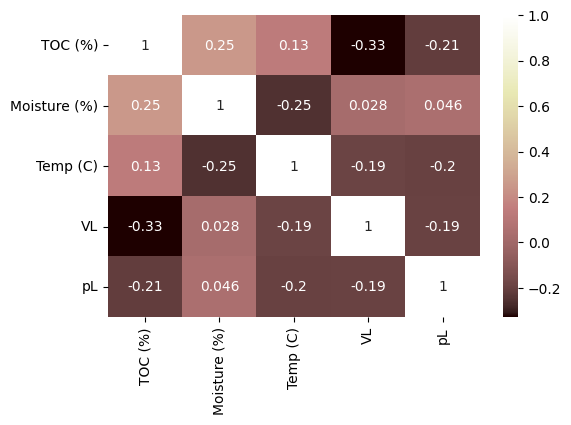

In [ ]:
sns.heatmap(df.corr(), cmap="pink", annot=True)

In [ ]:
df['Rock'].unique()

array(['Shale/Clay', 'Coal'], dtype=object)

In [ ]:
df['Gas'].unique()

array(['CH4'], dtype=object)

### One-hot encoding for the Gas and Rock columns:

In [ ]:
gas_dic = {'CH4': 0, 'CO2': 1}
df.Gas = [gas_dic[item] for item in df.Gas]

In [ ]:
rock_dic = {'Shale/Clay': 0, 'Coal': 1}
df.Rock = [rock_dic[item] for item in df.Rock]

In [ ]:
x = df.drop(['VL', 'pL'],axis=1)
y = df[['VL', 'pL']]

### Because we have only C1 here, I am going to drop the Gas column:

In [ ]:
x = x.drop(['Gas'], axis=1)

In [ ]:
x.head()

,Rock,TOC (%),Moisture (%),Temp (C)
0,0,0.003959,0.089918,0.166667
1,0,0.000000,0.205722,0.066667
2,0,0.035743,0.200272,0.066667
3,0,0.003280,0.254768,0.066667
4,0,0.007465,0.080381,0.066667


In [ ]:
x['Rock'].unique()

array([0, 1])

In [ ]:
RAND_STAT = 200

In [ ]:
#Create train and test dataset with an 80:20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=RAND_STAT)
#Further divide training dataset into train and validation dataset with an 90:10 split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=RAND_STAT)
#Check the sizes of all newly created datasets
print("Shape of x_train:",x_train.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_val:",y_val.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (100, 4)
Shape of x_val: (12, 4)
Shape of x_test: (6, 4)
Shape of y_train: (100, 2)
Shape of y_val: (12, 2)
Shape of y_test: (6, 2)


In [ ]:
x_train=np.asarray(x_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)
x_val=np.asarray(x_val).astype(np.float32)
y_val=np.asarray(y_val).astype(np.float32)

In [ ]:
history = History()
#Defining Functional model
input_layer = Input(shape=(4,))
Layer_1 = Dense(100,activation="relu")(input_layer)
Layer_2 = Dense(80,activation="relu")(Layer_1)
output_layer = Dense(2,activation="tanh")(Layer_2)
model = Model(inputs=input_layer, outputs=output_layer)
#Configure the model
keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3, amsgrad=True)
model.compile(optimizer='adam', loss="mean_absolute_error", metrics=["accuracy"])
#Train the model
model.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=80,batch_size=8,callbacks=[history])

Epoch 1/80
13/13 [==============================] - 1s 31ms/step - loss: 0.1907 - accuracy: 0.4500 - val_loss: 0.1504 - val_accuracy: 0.6667
Epoch 2/80
13/13 [==============================] - 0s 9ms/step - loss: 0.1498 - accuracy: 0.4900 - val_loss: 0.1166 - val_accuracy: 0.7500
Epoch 3/80
13/13 [==============================] - 0s 10ms/step - loss: 0.1593 - accuracy: 0.5400 - val_loss: 0.1606 - val_accuracy: 0.1667
Epoch 4/80
13/13 [==============================] - 0s 9ms/step - loss: 0.1530 - accuracy: 0.5800 - val_loss: 0.1447 - val_accuracy: 0.7500
Epoch 5/80
13/13 [==============================] - 0s 8ms/step - loss: 0.1489 - accuracy: 0.5800 - val_loss: 0.1423 - val_accuracy: 0.6667
Epoch 6/80
13/13 [==============================] - 0s 10ms/step - loss: 0.1462 - accuracy: 0.6100 - val_loss: 0.1444 - val_accuracy: 0.7500
Epoch 7/80
13/13 [==============================] - 0s 9ms/step - loss: 0.1470 - accuracy: 0.6000 - val_loss: 0.1244 - val_accuracy: 0.6667
Epoch 8/80
13/13 

In [ ]:
x_test=np.asarray(x_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)

In [ ]:
result = model.evaluate(x_test,y_test)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

1/1 [==============================] - 0s 25ms/step - loss: 0.0869 - accuracy: 0.5000
Metric  loss : 0.09
Metric  accuracy : 0.5


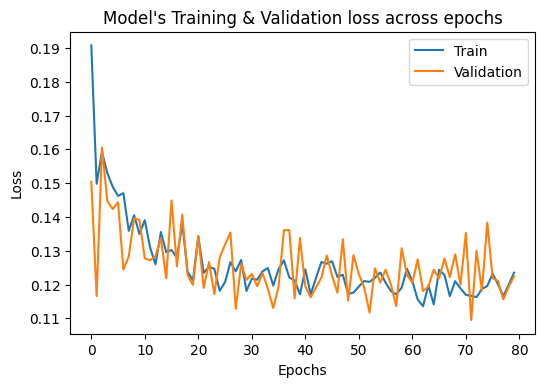

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [ ]:
predicted = model.predict(df.drop(['Gas', 'VL', 'pL'], axis=1).to_numpy())

In [ ]:
expected = df.drop(['Gas', 'Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)'], axis=1).to_numpy()

In [ ]:
def linear_model_results(axes_num, y_actual, y_prediction, title):
    linear_model = LinearRegression().fit(y_actual.reshape(-1, 1), y_prediction.reshape(-1, 1))
    r_sq = linear_model.score(y_actual.reshape(-1, 1), y_prediction.reshape(-1, 1))
    print('coefficient of determination:', r_sq)
    print('coef_:', linear_model.coef_)
    print('intercept:', linear_model.intercept_)
    
    axes[axes_num].plot(y_actual,  linear_model.coef_[0][0] * y_actual + linear_model.intercept_[0],
                linestyle='--', color = 'darkblue')  
    axes[axes_num].scatter(y_actual, y_prediction,
                            linewidths=2, edgecolor='black', color = 'lightblue') 
    axes[axes_num].set_xlabel('Actual')
    axes[axes_num].set_ylabel(title)

coefficient of determination: 0.43598652398141047
coef_: [[0.7208324]]
intercept: [0.04296064]


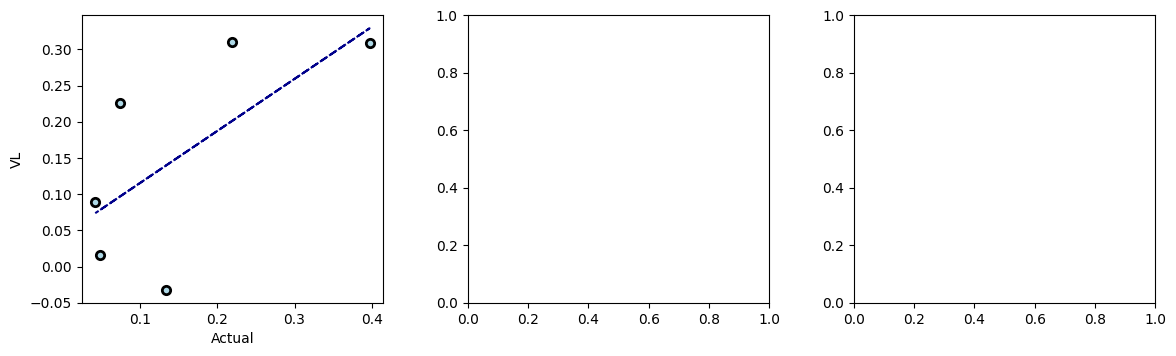

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_test[:,0], y_test_pred[:,0], 'VL')

coefficient of determination: 0.1898765107975655
coef_: [[0.26209098]]
intercept: [0.15638357]


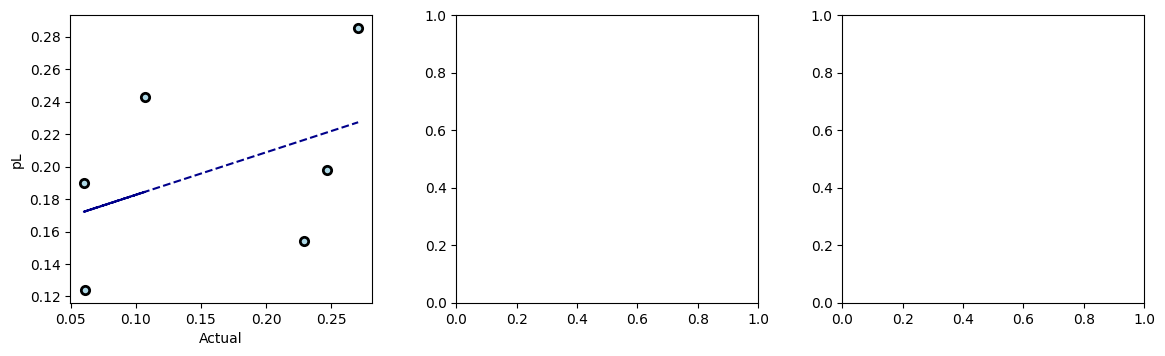

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_test[:,1], y_test_pred[:,1], 'pL')

coefficient of determination: 0.23726478567739762
coef_: [[0.918063]]
intercept: [0.08940196]


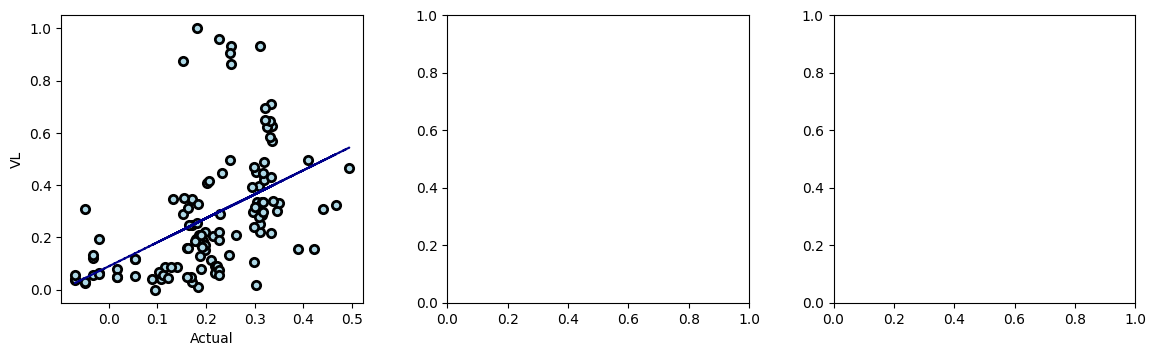

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, predicted[:,0], expected[:,0], 'VL')

coefficient of determination: 0.12682324409272794
coef_: [[0.9516649]]
intercept: [-0.00485654]


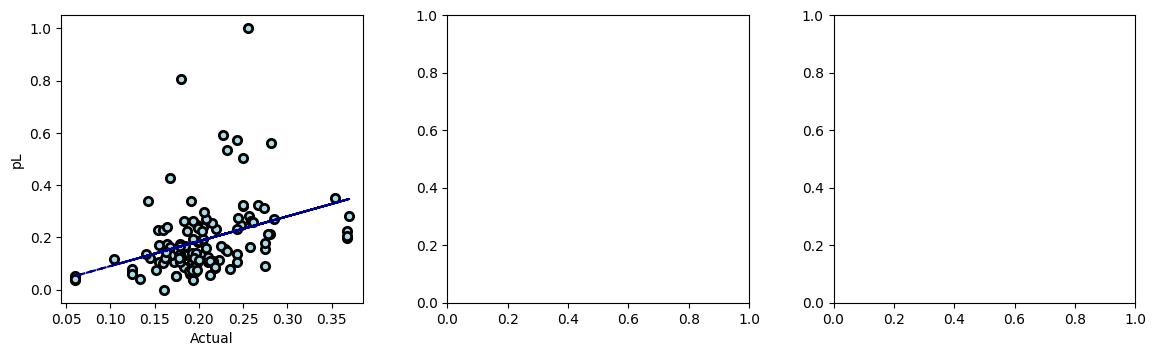

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, predicted[:,1], expected[:,1], 'pL')

In [ ]:
pd.DataFrame(predicted, columns=['VL', 'pL'])

In [ ]:
df

In [ ]:
x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test)
y_test_pred = pd.DataFrame(y_test_pred)

In [ ]:
x_test.head()

In [ ]:
y_test.head()

In [ ]:
x_test = x_test.rename(columns={0: 'Rock', 1: 'TOC (%)', 2: 'Moisture (%)', 3: 'Temp (C)'})
y_test = y_test.rename(columns={0: 'VL', 1: 'pL'})
y_test_pred = y_test_pred.rename(columns={0: 'VL', 1: 'pL'})

In [ ]:
rock_dic = {0: 'Shale/Clay', 1: 'Coal'}
x_test.Rock = [rock_dic[item] for item in x_test.Rock]

In [ ]:
cols = ['TOC (%)', 'Moisture (%)', 'Temp (C)']
for col in cols:
  norm = MinMaxScaler().fit(df_backup[[col]])
  x_test[[col]] = norm.inverse_transform(x_test[[col]])

In [ ]:
cols = ['VL', 'pL']
for col in cols:
  norm = MinMaxScaler().fit(df_backup[[col]])
  y_test[[col]] = norm.inverse_transform(y_test[[col]])
  y_test_pred[[col]] = norm.inverse_transform(y_test_pred[[col]])

In [ ]:
x_test

In [ ]:
y_test

In [ ]:
y_test_pred